## Notebook 3

Import the needed libraries

In [1]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import Image, display

Load the model trained 

In [2]:
# Load the pre-trained model
model = load_model('celebrity_face_recognition_model.h5')

Open the weights file and the config file 

In [3]:
weights_path = "opencv_face_detector_uint8.pb"
config_path = "opencv_face_detector.pbtxt"
print(os.path.exists(weights_path))  
print(os.path.exists(config_path))

True
True


Load the model using the weights and the config file 

In [4]:
try:
    net = cv2.dnn.readNetFromTensorflow(weights_path,config_path)
    print("Model loaded successfully.")
except cv2.error as e:
    print("Error loading model:", e)

Model loaded successfully.


Open the class labels file that have been saved & class embedding file 

In [5]:
# Load class_labels from the saved file on Google Drive
with open('class_labels.pkl', 'rb') as f:
    class_labels = pickle.load(f)

threshold = 0.7

num_classes = 105 # Number of classes for face recognition

# Load class embeddings
with open('class_embeddings.pkl', 'rb') as f:
    class_embeddings = pickle.load(f)

Create a function that detect the face and make a box on it and see the cosine similarity for the image give so know to which class it belongs and if it doesn't belong to any give "Not Identified"

In [6]:
def process_frame(frame):
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")

            face_img = frame[startY:endY, startX:endX]
            face_img = cv2.resize(face_img, (224, 224))
            face_img = img_to_array(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            face_img = face_img / 255.0

            # Perform face recognition
            predictions = model.predict(face_img)

            # Calculate cosine similarity with each class
            similarities = []
            for class_name, embeddings in class_embeddings.items():
                class_embedding = np.mean(embeddings, axis=0)  # Assuming embeddings is a list of embeddings for each image
                similarity = cosine_similarity(predictions, class_embedding)
                similarities.append(similarity)

            max_similarity = max(similarities)
            if max_similarity >= threshold:
                predicted_class_idx = np.argmax(similarities)
                predicted_class_label = class_labels[predicted_class_idx]
            else:
                predicted_class_label = "Not Identified"

            # Display the recognized face and the person's name or "No Class"
            cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(frame, predicted_class_label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return frame

Create a function that take photo from the camera (live image)

In [7]:
def take_photo():
    # Initialize the webcam (0 is the default webcam)
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        raise Exception("Could not open video device")

    # Set the resolution for the video capture
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    # Capture one frame from the webcam
    ret, frame = cap.read()

    if not ret:
        raise Exception("Failed to capture image")

    # Save the captured frame to a file
    filename = "test_image.jpg"
    cv2.imwrite(filename, frame)

    # Release the webcam
    cap.release()

    return filename

Try the cosine similarity from static image

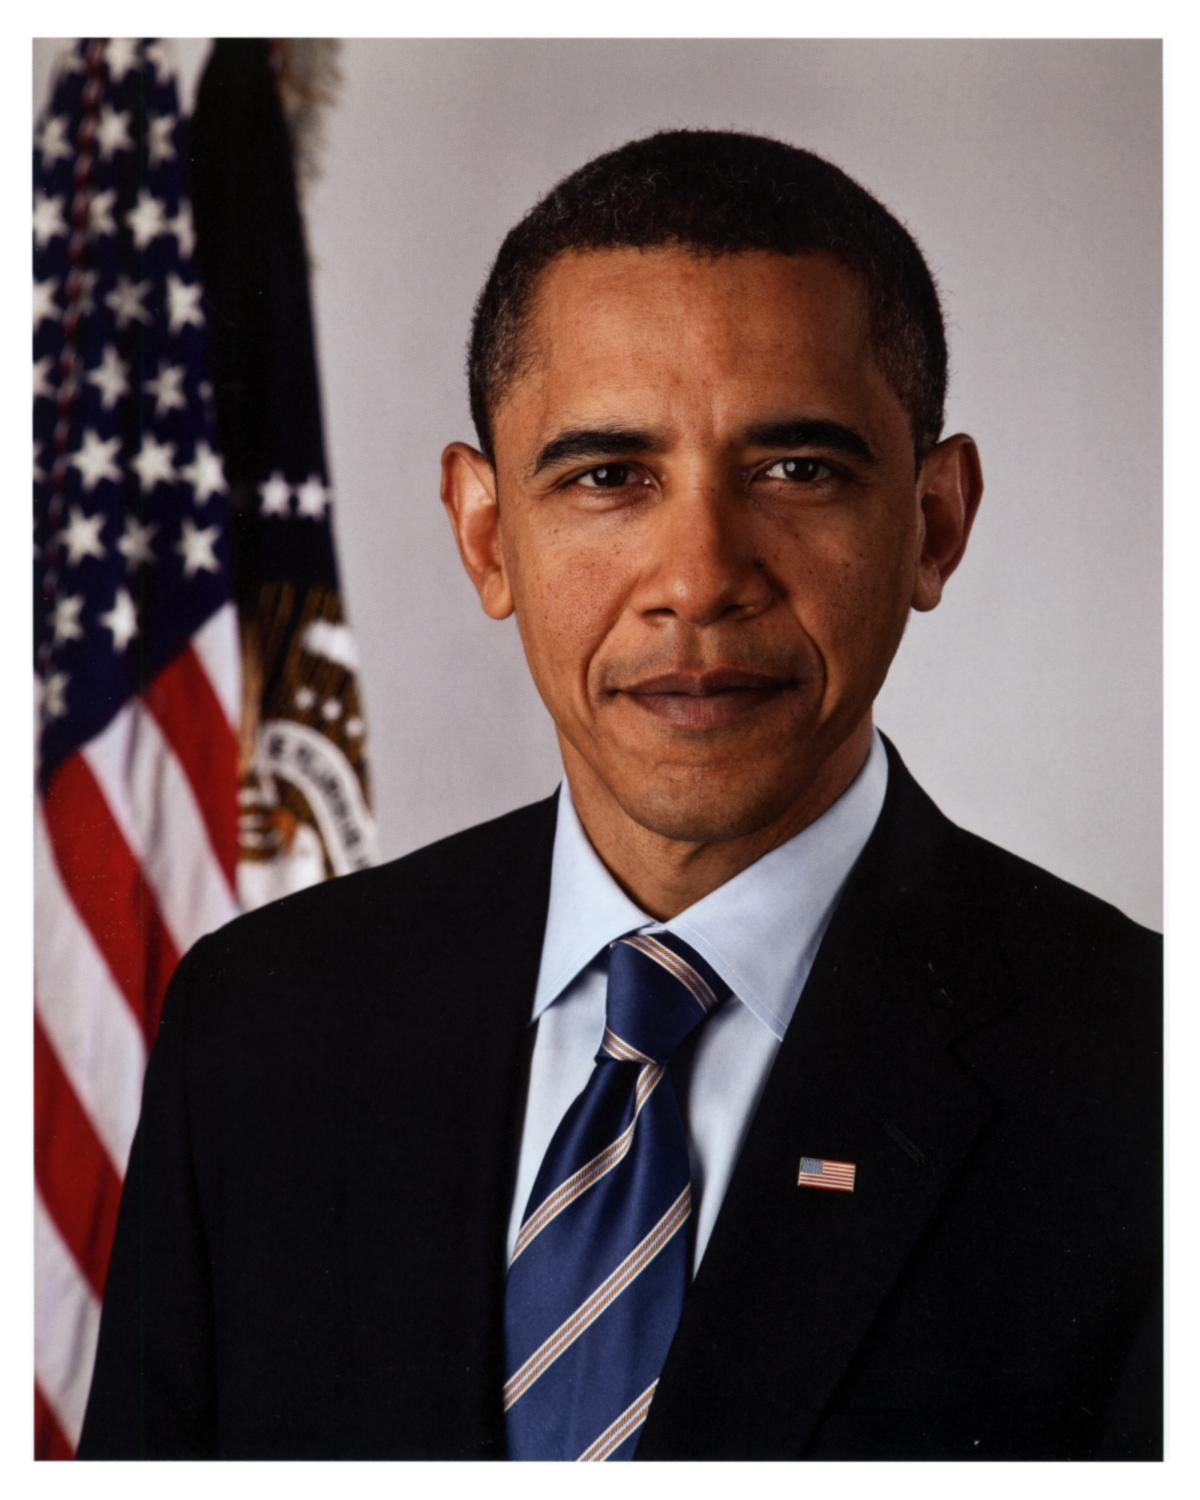

1/1 [==============================] - 2s 2s/step


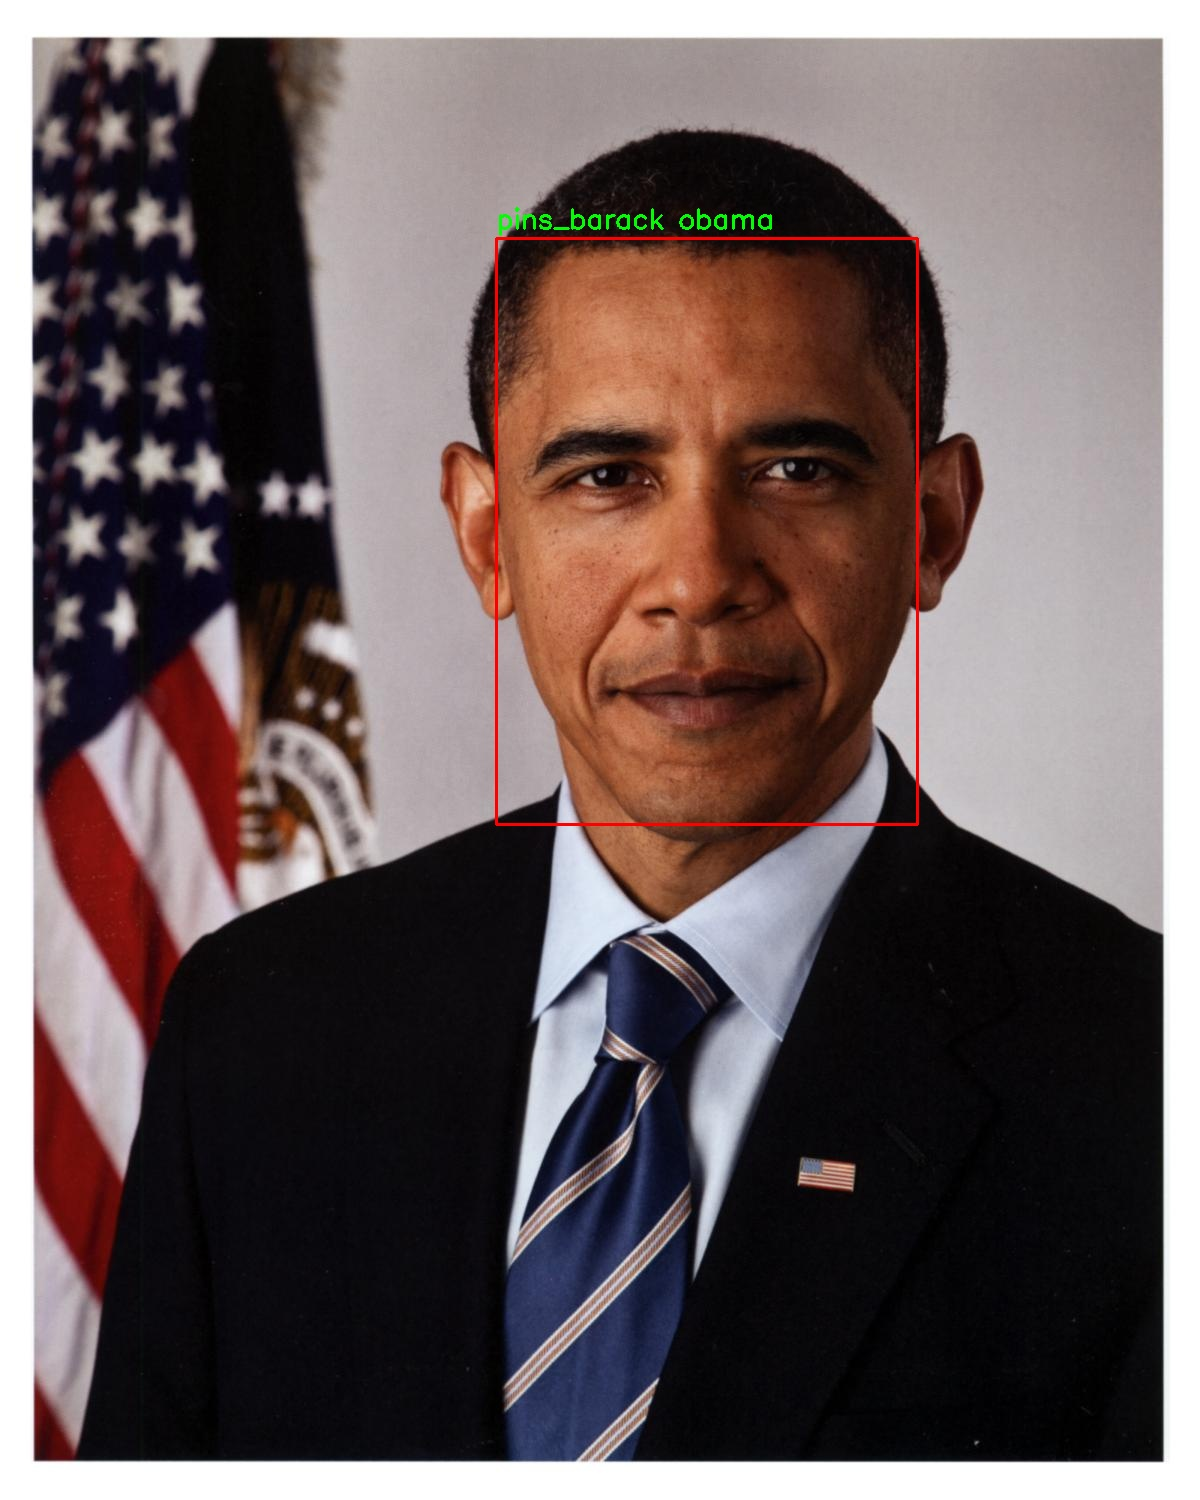

In [8]:
try:
    # try on an image 
    filename = 'obama.jpg'
    display(Image(filename))
    # Read the captured image
    frame = cv2.imread(filename)

    # Process the frame for face recognition
    processed_frame = process_frame(frame)
    # Save the processed frame to a temporary file, if needed
    temp_filename = "processed_image.jpg"
    cv2.imwrite(temp_filename, processed_frame)  # Save processed image

    # Display the processed frame
    display(Image(temp_filename))  # Display the saved processed image


except Exception as e:
    # If an error occurs, print the error and continue
    print(str(e))

# (Bonus 1)

Take image from live camera feed not static image

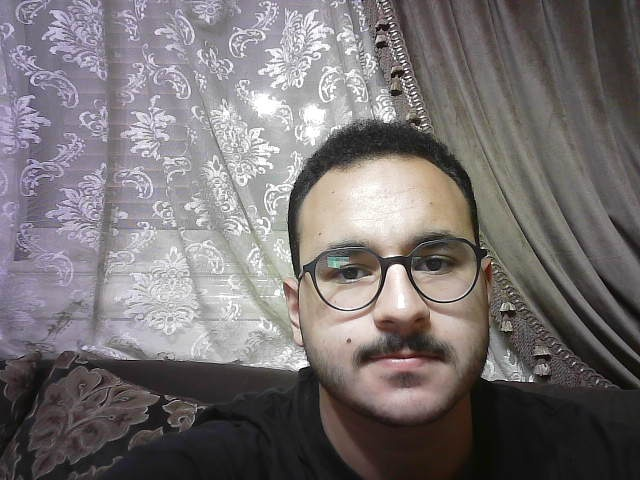

1/1 [==============================] - 0s 50ms/step


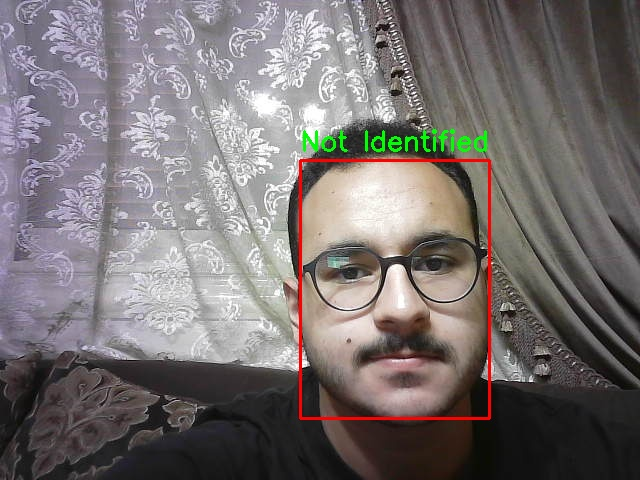

In [10]:
try:
    # Capture a photo
    filename = take_photo()
    display(Image(filename))
    # Read the captured image
    frame = cv2.imread(filename)

    # Process the frame for face recognition
    processed_frame = process_frame(frame)
    # Save the processed frame to a temporary file, if needed
    temp_filename = "processed_image.jpg"
    cv2.imwrite(temp_filename, processed_frame)  # Save processed image

    # Display the processed frame
    display(Image(temp_filename))  # Display the saved processed image

except Exception as e:
        # If an error occurs, print the error and continue
    print(str(e))

# (Bonus 2)

Create a function that make live stream (video) 

In [11]:
# Test live camera feed
cap = cv2.VideoCapture(0)
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Process the frame for face recognition
        processed_frame = process_frame(frame)

        cv2.imshow("Face Recognition", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except KeyboardInterrupt:
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 48ms/step
